In [7]:
from application.inception import *
from application.WEIGHTS import *
from application.inception_resnet_v2 import *
from application.inception_resnet_v2_se import *
weights = InceptionResNetV2_Weights()


In [8]:
img_input = keras.layers.Input(shape=[299, 299, 3])

In [9]:
# x = stem.conv0(img_input)
# print(x.shape)
# x = stem.conv1(x)
# print(x.shape)
# x = stem.conv2(x)
# print(x.shape)
# x = stem.max_pool3(x)
# print(x.shape)
# x = stem.conv4(x)
# print(x.shape)
# x = stem.conv5(x)
# print(x.shape)
# x = stem.max_pool6(x)
# print(x.shape)

In [10]:
model = InceptionResNetV2SEBlock()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
keras_model = keras.applications.InceptionResNetV2(weights=None, classes=150)
keras_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_853 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_813 (BatchN (None, 149, 149, 32) 96          conv2d_853[0][0]                 
__________________________________________________________________________________________________
activation_852 (Activation)     (None, 149, 149, 32) 0           batch_normalization_813[0][0]    
________________________________________________________________________________

In [11]:
import kfood_dataset
batch_size = 32
randomize = True
paths = kfood_dataset.get_image_paths()

finding image paths...
shuffling...
paths ready!


In [12]:
from sklearn.model_selection import train_test_split

# train : 0.64, test : 0.2, valid : 0.16
train_paths_full, test_paths = train_test_split(paths, test_size=0.2)
train_paths, valid_paths = train_test_split(train_paths_full, test_size=0.2)

In [13]:
len(train_paths), len(valid_paths), len(test_paths)

(96323, 24081, 30102)

In [14]:
import tensorflow as tf

train_set = kfood_dataset.make_kfood_dataset(train_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=len(paths[30000:]) // batch_size, randomize=randomize)
valid_set = kfood_dataset.make_kfood_dataset(valid_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=batch_size, shuffle_buffer_size=10000 // batch_size, randomize=randomize)
test_set = kfood_dataset.make_kfood_dataset(test_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=1, randomize=False)

2022-02-04 20:04:42.593800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-02-04 20:04:42.985179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
2022-02-04 20:04:43.416411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


고등어구이
된장찌개
부추김치
수정과


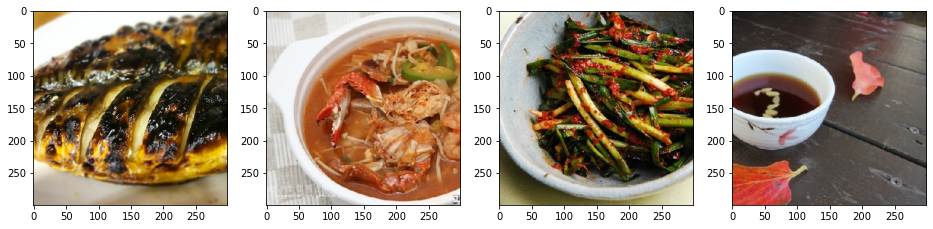

In [15]:
kfood_dataset.plot_dataset_image_4(train_set)

In [16]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [76]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import os

class ModelSaver(keras.callbacks.Callback):
    def __init__(self, now, model_paths,**kwargs):
        self.now = now
        self.model_paths = model_paths
        self.loss = np.array([])
    
    def on_epoch_end(self, epoch, logs={}):
        fileformats = [self.now.year, self.now.month, self.now.day, self.now.hour, self.now.minute, epoch]
        self.model.save(self.model_paths + "/{}_{}_{}_{}_{}_{}.hd5".format(*fileformats))
        
        self.loss = np.append(self.loss, logs["loss"])
        plt.plot(np.arange(1, epoch+2), self.loss)
        plt.axis([1, 10, 1, self.loss[0]+0.5])
        plt.savefig(self.model_paths + "/loss.png", format="png", dpi=300)
        
        


In [77]:
from datetime import datetime
model_paths = "drive/MyDrive/Model/kfood/{}/{}"
model_name = "CustomInceptionResNetV2"
train_property = "SGD_Random"

model_saver = ModelSaver(datetime.now(), model_paths.format(model_name, train_property))
bestmodel_saver = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_paths.format(model_name, train_property) + "/best",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

[0 1 2 3 4 5 6 7 8] [5.06993389 5.0677104  5.10791492 4.94802427 5.1117878  5.07163191
 5.01957512 5.07117367 4.97075081 5.10120964]


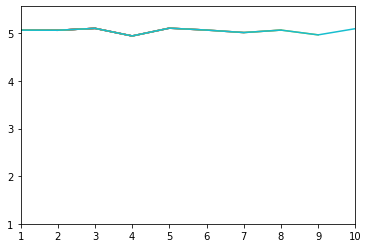

In [78]:

history = model.fit(train_set, steps_per_epoch=1,
          validation_data=valid_set, validation_steps=1, 
          epochs=10,
          callbacks=[model_saver]
          )